# How to weaponize the randomness of k-means

## Introduction: The Problem

A typical introductory text about the k-means algorithm will state that one of the main issues in using this algorithm is that the user has to set the number of clusters beforehand. **Never mind the number of clusters: How do you know if your data actually has any structure at all?** If the probability distributions underlying your dataset (sometimes called the "data generating distributions") do not have any cluster structure, then any solution found by the k-means algorithm will be completely random. Even if your data has structure, then generally multiple runs of k-means will not produce identical clusterings.

In this notebook I will show a way to use this randomness of clusterings found by k-means to identify whether your data has cluster structure and how many clusters k-means can reasonably find.

I'll start with an example of how a dataset with two unrelated and normally distributed features leads to random solutions.

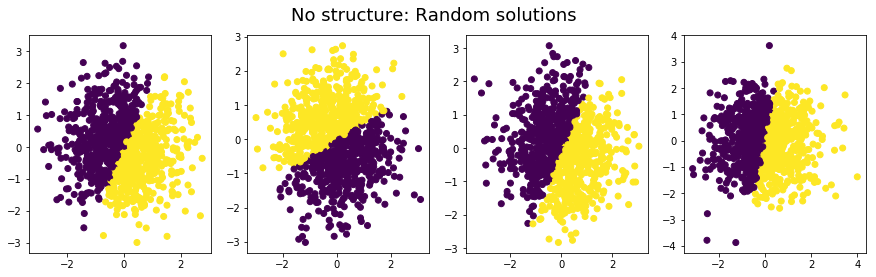

In [57]:
%matplotlib inline

import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

n = 1000

def genNormalData(n, seed):
    x = []
    for xi in range(n):
        x.append(normal())
    return x

fig = gcf()
fig.suptitle("No structure: Random solutions", fontsize=18)
#plt.figure(1, figsize=(12, 4))
fig.set_figheight(4)
fig.set_figwidth(15)

# Just so this notebook is exactly reproducible:
np.random.seed(0)

for i in range(4):
    x1 = genNormalData(n, seeds[i])
    x2 = genNormalData(n, seeds[i + 4])
    X = np.array([x1, x2]).T 
    kmeans = KMeans(2, init='random')
    clusters = kmeans.fit_predict(X)
    plt.subplot(141 + i)
    plt.scatter(x1, x2, c=clusters)

In real life, you're unlikely to be able to conveniently visualize your data like I've done here. So we're going to need a more algorithmic approach to figuring out if your solution is random and if your data has any structure to it. So let's generate a toy dataset that we can play with.

## A Toy Dataset With Some Structure

To investigate some possible approaches that may work to identify random solutions and/or structure, let's take a look at this dataset, with four clusters with uniformly distributed datapoints.


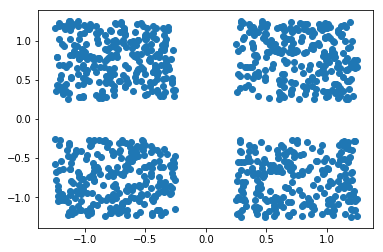

In [58]:
import numpy as np
from numpy.random import uniform

n = 1000

def gen(n, l=1, split=True):
    x = []
    for xi in range(n):
        #r = uniform() * 2 * l + 1
        #if split and r > 2:
        #    r = r + 0.5       
        r = uniform() * 2 * l - 1
        if split and r > 0:
            r = r + 0.25
        else:
            r = r - 0.25
        x.append(r)
    return x

# Just so this notebook is exactly reproducible:
np.random.seed(0)

x = gen(n)
y = gen(n)
#y = gen(n, 1, False) # elongated along y axis

xmin = -1.6
xmax = 1.6

X = np.array([x, y]).T 

plt.scatter(x, y)

## Running K-Means on the Toy

From the visuailzations it's obvious that this dataset has 4 clusters, but of course in practical situations, this will not be so obvious. Let's see what happens when we try to cluster this dataset with 2, 3, 4 or 5 clusters.

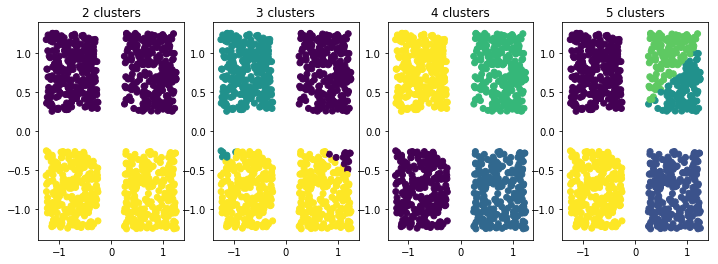

In [59]:
import matplotlib.pyplot as plt

X = np.array([x, y]).T 

plt.figure(1, figsize=(12, 4))

for i in range(4):
    k = 2 + i
    kmeans = KMeans(k, init='random')
    clusters = kmeans.fit_predict(X)    
    plt.subplot(141 + i)
    plt.title(str(k)+ " clusters")
    plt.scatter(x, y, c=clusters)

If we look at any of these clusterings, all except for the solution with 4 clusters are random. The solution with 2 clusters could randomly join both left and right clusters, or it could form a cluster of the top squares and another cluster containing the bottom squares.

Looking at the solution with 3 clusters, we see that K-means has chosen to join the bottom two squares. Given the data generating probability distributions, it could have equally probably chosen the top two squares, or two on the left or the two on the right. However, *given our data sample, it will almost always choose to merge the bottom two.

Here are the centroids from running K-means with k=3 100 times:

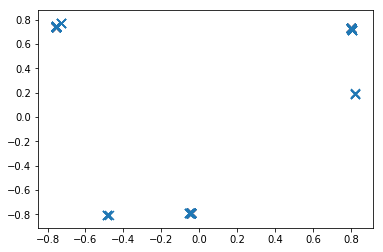

In [93]:
np.random.seed(0)

def get_cluster_centers(X, k, loops):
    kmeans = KMeans(k, n_jobs=-1, init='random')    
    # n_jobs=-1 tells it to use all available CPUs

    allclusters = []
    for i in range(loops):
        kmeans.fit(X)
        centers = kmeans.cluster_centers_
        for c in centers:
            allclusters.append(c)

    x_ac = [p[0] for p in allclusters]
    y_ac = [p[1] for p in allclusters]
    return (x_ac, y_ac)

(x_ac, y_ac) = get_cluster_centers(X, 3, 100)

plt.scatter(x_ac, y_ac, marker='x', s=80)

## So now we have two problems

First, the solution is random, and second, rerunning k-means isn't displaying the random behaviour, suggesting actually a very stable solution.

Knowing that the solution is random, we should find a KPI of some kind, that correctly reports that this is so.
One solution is to apply a variant of k-fold cross validation. Using for instance 5-folds, the idea is normally to split the data into 5 chunks and run the clustering 5 times, each time on 80% of the data but a different subset of the sample. Unfortunately, we observe that using 80% of the data, the clustering remains equally stable. But this changes if we run on 20% instead: Running first on the first 20%, then on the second 20%, and so on.

The higher the number of folds, the more reliably we can demonstrate randomness, but if we choose too many folds, for example 100, in this case we would only have 10 points left per clustering, and using 3 clusters we would expect the results to show random results even if the underlying distributions contain three clusters.

## Using Folds to Bring out the Randomness

We split the data into 20 folds and cluster each fold individually. Behold randomness:

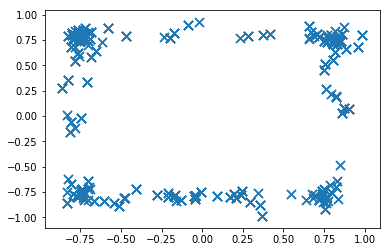

In [108]:
from sklearn.model_selection import KFold

np.random.seed(0)

n_clusters = 4
n_splits = 2

def get_clusters_using_folds(X, n_clusters, n_splits):
    kfold = KFold(n_splits=n_splits)
    x_ac = []
    y_ac = []
    for train_index, test_index in kfold.split(X):
        (x_fold, y_fold) = get_cluster_centers(X[test_index], k=n_clusters, loops=1)
        for x in x_fold:
            x_ac.append(x)
        for y in y_fold:
            y_ac.append(y)
    return (x_ac, y_ac)

(x_wfolds, y_wfolds) = get_clusters_using_folds(X, n_clusters, n_splits)

plt.scatter(x_wfolds, y_wfolds, marker='x', s=80)

## Load MNIST

In [399]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from umap import UMAP

(data, target) = load_digits(return_X_y=True)

data = scale(data)
#X = PCA(n_components=2).fit_transform(data)
#x = []
#y = []

umapper = UMAP(n_neighbors=5, min_dist=0.3, metric='correlation')
X = umapper.fit_transform(data)
     
x = [x[0] for x in X]
y = [x[1] for x in X]

## Load the Iris dataset

In [408]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

X = scale(load_iris().data)

X_pca = PCA(n_components=2).fit_transform(X)

x = [x[0] for x in X]
y = [x[1] for x in X]

## Clustering

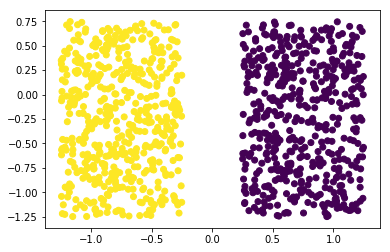

In [358]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(2, init='random')
clusters = kmeans.fit_predict(X)

#plt.xlim(-5, 5)
plt.scatter(x, y, c=clusters)


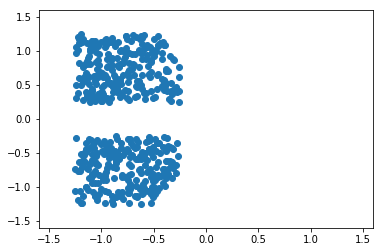

In [199]:
c = 1
color2 = filter(lambda point: point[2]==c, np.array([x, y, clusters]).T)
points = [p for p in color2]
xc2 = [point[0] for point in points]
yc2 = [point[1] for point in points]

plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)
plt.scatter(xc2, yc2)

## Test stability of the clustering

If we run many times, do we always get the same results?

Plot the cluster centers of many runs of the k-means algorithm.

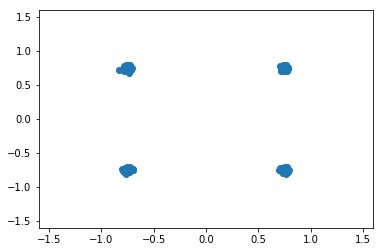

In [241]:
runs = 100
k = 4
allclusters = []

for i in range(runs):
    x = gen(n)
    y = gen(n)
    X = np.array([x, y]).T
    kmeans = KMeans(k, init='random')
    kmeans.fit(X)
    centers = kmeans.cluster_centers_
    for c in centers:
        allclusters.append([c[0], c[1]])
    
x_ac = [p[0] for p in allclusters]
y_ac = [p[1] for p in allclusters]

plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)
plt.scatter(x_ac, y_ac)

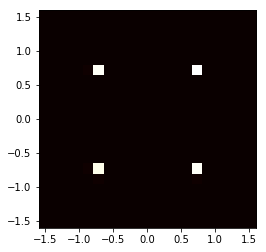

In [242]:
heatmap, xedges, yedges = np.histogram2d(x_ac, y_ac, bins=20, range=[[xmin, xmax], [xmin, xmax]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)

plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='hot')

## Stability of clustering using K-fold validation

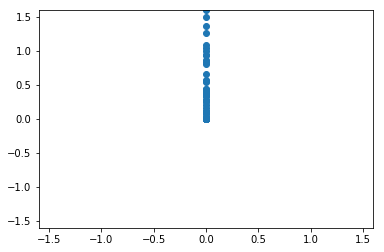

In [368]:
from sklearn.model_selection import KFold

k = 10

def validateClusterCenters(X, k):
    allclusters = []
    
    splits = 10
    kf = KFold(n_splits=splits)
    
    for train_index, test_index in kf.split(X):
        kmeans = KMeans(k, n_jobs=-1, init='random')
        kmeans.fit(X[test_index])
        centers = kmeans.cluster_centers_
        for c in centers:
            allclusters.append(c)
    
    return allclusters

ac = validateClusterCenters(X, k)

x_ac = [p[0] for p in ac]
y_ac = [p[1] for p in ac]

#plt.xlim(xmin, xmax)
#plt.ylim(xmin, xmax)
plt.scatter(x_ac, y_ac)

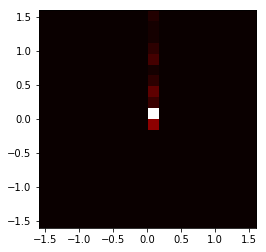

In [370]:
heatmap, xedges, yedges = np.histogram2d(x_ac, y_ac, bins=20, range=[[xmin, xmax], [xmin, xmax]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

#plt.xlim(xmin, xmax)
#plt.ylim(xmin, xmax)

plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='hot')

## Elbow method

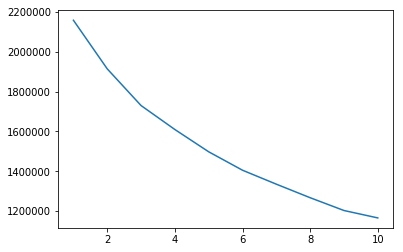

In [371]:
k_arr = [k+1 for k in range(10)]

def getElbowScores(X, k_arr):
    elbow_scores = []
    for k in k_arr:
        kmeans = KMeans(k, init='random')
        kmeans.fit(X)
        elbow_scores.append(-kmeans.score(X))
    return elbow_scores
    
plt.plot(k_arr, getElbowScores(X, k_arr))

## Putting it all together

* Split the data into 10 folds
* For each k:
  * Run clustering on all folds, generating 10 times k cluster centers
  * The cluster centers should be indicators of true clusters so they should always be in the same positions:
  * Run a clustering on the cluster centers using the same k. For real clusters, this should result in k very compact clusters and therefore in a low score of the k-means run.
  * Store the score of the k-means run for this k.
* Plot the scores versus k. The true number of clusters has the lowest score.

In [409]:
k_arr = [k+1 for k in range(10)]

# Return score and variance after clustering cluster centers
# - score: how close do the cluster centers that we find cluster together?
# - variance: what is the variance on the number of times that we find each cluster?
def getScoreAndVariance(X, k):
    Xk = validateClusterCenters(X, k)
    
    kmeans = KMeans(k, n_jobs=-1, init='random')
    clusters = kmeans.fit_predict(Xk)
    score = -kmeans.score(Xk) 
    hist = np.histogram(clusters, bins=k)
    variance = np.var(hist[0])
    return (score, variance)
    
scores = []
variances = []
for k in k_arr:
    (s, v) = getScoreAndVariance(X, k)
    print("k=%d: Score=%5.2f Variance=%5.2f" % (k, s, v))
    scores.append(s)
    variances.append(v)

k=1: Score=26.77 Variance= 0.00
k=2: Score=20.00 Variance= 9.00
k=3: Score=27.79 Variance= 0.67
k=4: Score=37.46 Variance=17.50
k=5: Score=31.63 Variance= 6.80
k=6: Score=34.45 Variance=21.00
k=7: Score=36.94 Variance=46.86
k=8: Score=38.78 Variance=32.25
k=9: Score=37.39 Variance=10.00
k=10: Score=33.67 Variance=13.20


In [410]:
elbow_scores = getElbowScores(X, k_arr)

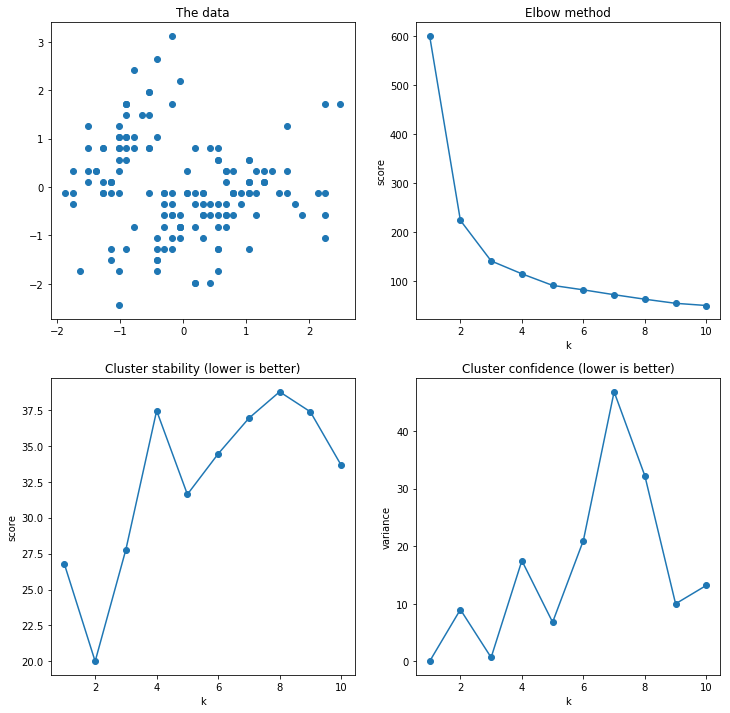

In [411]:
plt.figure(1, figsize=(12, 12))

plt.subplot(221)
plt.scatter(x,y)
plt.title('The data')

plt.subplot(222)
plt.plot(k_arr,elbow_scores, marker='o')
plt.title('Elbow method')
plt.xlabel('k')
plt.ylabel('score')

plt.subplot(223)
plt.plot(k_arr, scores, marker='o')
plt.xlabel('k')
plt.ylabel('score')
plt.title('Cluster stability (lower is better)')

plt.subplot(224)
plt.plot(k_arr, variances, marker='o')
plt.xlabel('k')
plt.ylabel('variance')
plt.title('Cluster confidence (lower is better)')

plt.savefig('ks_choice.png')

## Show regions assigned to clusters

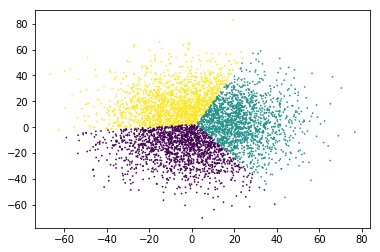

In [102]:
from numpy.random import standard_normal as gauss

n = 5000

def genGauss(n, l=1, split=True):
    x = []
    for xi in range(n):
        r = 20*gauss() + 2.25
        x.append(r)
    return x

xG = genGauss(n)
yG = genGauss(n)

cG = kmeans.predict(np.array([xG, yG]).T)

#plt.xlim(-5, 5)
plt.scatter(xG, yG, c=cG, s=0.5)


## Clustering features with very different variance

... will give very bad results

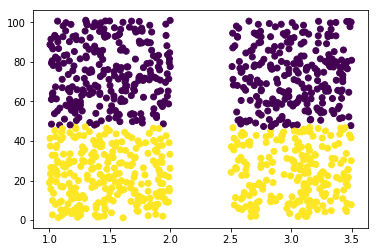

In [87]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(2)

clusters = ac.fit_predict(X)

#plt.xlim(-5, 5)
plt.scatter(x, y, c=clusters)